# 📊 Dataset Analysis: Bitcoin Price Prediction

This notebook contains comprehensive Exploratory Data Analysis (EDA) of the Cryptify dataset.

**Dataset:** BTC/USDT hourly data with engineered features  
**Sources:** Binance (OHLCV), Bybit (Open Interest), Yahoo Finance (S&P 500)  
**Period:** 2+ years of historical data

## Contents:
1. Data Loading and Basic Statistics
2. Price Analysis (if raw_bars available)
3. Feature Distribution Analysis
4. Correlation Analysis
5. Volatility Analysis
6. Volume Analysis
7. Technical Indicators Analysis
8. Temporal Patterns (Hourly, Daily, Monthly)
9. Data Quality Checks



In [3]:
!pip install -r requirements.txt

     ---------------------------------------- 0.0/15.7 MB ? eta -:--:--
     - -------------------------------------- 0.5/15.7 MB 5.4 MB/s eta 0:00:03
     ------------------------- ------------- 10.2/15.7 MB 37.5 MB/s eta 0:00:01
     --------------------------------------- 15.7/15.7 MB 43.2 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      + C:\Users\shara\anaconda3\python.exe C:\Users\shara\AppData\Local\Temp\pip-install-_1g79yhl\numpy_14fc5093ac7b45b9aae3382d45538a37\vendored-meson\meson\meson.py setup C:\Users\shara\AppData\Local\Temp\pip-install-_1g79yhl\numpy_14fc5093ac7b45b9aae3382d45538a37 C:\Users\shara\AppData\Local\Temp\pip-install-_1g79yhl\numpy_14fc5093ac7b45b9aae3382d45538a37\.mesonpy-b2c7iv7q\build -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\shara\AppData\Local\Temp\pip-install-_1g79yhl\numpy_14fc5093ac7b45b9aae3382d45538a37\.mesonpy-b2c7iv7q\build\meson-python-native-file.ini
      The Meson build system
      Version: 1.2.99
      Source dir: C:\Users\shara\AppData\Local\Temp\pip-install-_1g79yhl\numpy_14fc5093ac7b45b9aae3382d45538a37
      Build dir: C:\Users\shara\AppData\Local\Temp\pip-install-_1g79yhl\numpy_14fc50

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")



✅ Libraries imported successfully
Pandas version: 2.2.3
NumPy version: 2.1.3


## 1. Data Loading from CSV or API Collection

We'll try to load data from CSV first. If CSV doesn't exist, we'll collect real data from APIs (Binance, Bybit, Yahoo Finance) just like in data_collector.py



In [8]:
!pip install pandas_ta

  Using cached pandas_ta-0.4.71b0-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 19.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------------------------------- 12.6/12.6 MB 69.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 11.0/11.0 MB 53.2 MB/s eta 0:00:00

  Attempting uninstall: numpy

    Found existing installation: numpy 2.1.3

   ---------------------------------------- 0/4 [numpy]
    Uninstalling numpy-2.1.3:
   ---------------------------------------- 0/4 [numpy]
      Successfully uninstalled numpy-2.1.3
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]


  You can safely remove it manually.
  You can safely remove it manually.


In [9]:
# Configuration for data collection
import os
import time
from pathlib import Path
import ccxt
import requests
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta

# CSV file paths
CSV_FEATURES_PATH = 'btc_features_1h.csv'
CSV_RAW_BARS_PATH = 'raw_bars.csv'

# API Configuration (same as data_collector.py)
EXCHANGE_ID = 'binance'
SYMBOL = 'BTC/USDT'
TIMEFRAME = '1h'
YEARS_TO_FETCH = 2  # Collect 2 years of data
SP500_TICKER = 'ES=F'
SP500_INTERVAL = '1h'
OI_SYMBOL_BYBIT = 'BTCUSDT'
OI_CATEGORY_BYBIT = 'linear'
OI_INTERVAL_BYBIT = '1h'
BASE_URL_BYBIT = "https://api.bybit.com"
ENDPOINT_OI_BYBIT = "/v5/market/open-interest"

COL_MAPPING = {
    'Open': 'BTC_Open',
    'High': 'BTC_High',
    'Low': 'BTC_Low',
    'Close': 'BTC_Close',
    'Volume': 'BTC_Volume',
    'SP500_Close': 'SP500_Close'
}

print("Configuration loaded")



Configuration loaded


In [10]:
# Check if CSV exists, if not - collect data from APIs
df_features = None

# Try to load from CSV
if os.path.exists(CSV_FEATURES_PATH):
    print(f"Loading data from {CSV_FEATURES_PATH}...")
    try:
        df_features = pd.read_csv(CSV_FEATURES_PATH, index_col='timestamp', parse_dates=['timestamp'])
        print(f"✅ Loaded {len(df_features)} rows from CSV")
        print(f"📅 Date range: {df_features.index.min()} to {df_features.index.max()}")
        print(f"📊 Features shape: {df_features.shape}")
        print(f"\nColumns: {list(df_features.columns)}")
    except Exception as e:
        print(f"⚠️ Error loading CSV: {e}")
        df_features = None

if df_features is None or df_features.empty:
    print("\n" + "="*80)
    print("CSV file not found. Collecting real data from APIs...")
    print("This will take several minutes (collecting 2 years of hourly data)")
    print("="*80)
    print("\nStarting data collection...")




CSV file not found. Collecting real data from APIs...
This will take several minutes (collecting 2 years of hourly data)

Starting data collection...


In [11]:
# Define helper and data collection functions (from data_collector.py)

def calculate_log_return(series, periods=1):
    """Calculate logarithmic return."""
    return np.log(series / series.shift(periods))

def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create engineered features from raw data."""
    df_temp = df.copy()
    
    # Create aliases for pandas_ta
    for old_name, new_name in COL_MAPPING.items():
        if new_name in df_temp.columns and old_name not in df_temp.columns:
            df_temp[old_name] = df_temp[new_name]
    
    if 'BTC_Open' in df_temp.columns and 'Open' not in df_temp.columns:
        df_temp['Open'] = df_temp['BTC_Open']
    
    # Main features
    if 'BTC_Close' in df_temp.columns:
        df_temp['Close'] = df_temp['BTC_Close']
    if 'BTC_High' in df_temp.columns:
        df_temp['High'] = df_temp['BTC_High']
    if 'BTC_Low' in df_temp.columns:
        df_temp['Low'] = df_temp['BTC_Low']
    if 'BTC_Volume' in df_temp.columns:
        df_temp['Volume'] = df_temp['BTC_Volume']
    
    df_temp['log_return'] = calculate_log_return(df_temp['Close'])
    if 'SP500_Close' in df_temp.columns:
        df_temp['SP500_log_return'] = calculate_log_return(df_temp['SP500_Close'])
    else:
        df_temp['SP500_log_return'] = 0
    
    # Price transformations
    prev_close = df_temp['Close'].shift(1)
    df_temp['price_range'] = (df_temp['High'] - df_temp['Low']) / prev_close
    df_temp['price_change'] = (df_temp['Close'] - df_temp['Open']) / df_temp['Open']
    
    # Volatility
    for window in [5, 14, 21]:
        df_temp[f'volatility_{window}'] = df_temp['log_return'].rolling(window=window).std()
        df_temp[f'volume_ma_{window}'] = df_temp['Volume'].rolling(window=window).mean()
    
    vol_mean_100 = df_temp['Volume'].rolling(100).mean()
    vol_std_100 = df_temp['Volume'].rolling(100).std()
    df_temp['volume_zscore'] = (df_temp['Volume'] - vol_mean_100) / vol_std_100
    
    # Technical indicators
    df_temp['prev_Close'] = df_temp['Close'].shift(1)
    df_temp['prev_High'] = df_temp['High'].shift(1)
    df_temp['prev_Low'] = df_temp['Low'].shift(1)
    
    macd_data = df_temp.ta.macd(close='prev_Close', fast=12, slow=26, signal=9)
    if macd_data is not None:
        df_temp['MACD_safe'] = macd_data.iloc[:, 0]
    
    rsi_data = df_temp.ta.rsi(close='prev_Close', length=14)
    if rsi_data is not None:
        df_temp['RSI_safe'] = rsi_data
    
    atr_data = df_temp.ta.atr(high='prev_High', low='prev_Low', close='prev_Close', length=14)
    if atr_data is not None:
        df_temp['ATR_safe_norm'] = atr_data / df_temp['prev_Close']
    
    df_temp.drop(['prev_Close', 'prev_High', 'prev_Low'], axis=1, inplace=True, errors='ignore')
    
    # Temporal features
    df_temp['hour_sin'] = np.sin(2 * np.pi * df_temp.index.hour / 24)
    df_temp['hour_cos'] = np.cos(2 * np.pi * df_temp.index.hour / 24)
    
    # Final cleanup - keep only feature columns
    feature_cols = ['log_return', 'SP500_log_return', 'price_range', 'price_change',
                    'volatility_5', 'volatility_14', 'volume_ma_5', 'volume_zscore',
                    'MACD_safe', 'RSI_safe', 'ATR_safe_norm', 'hour_sin', 'hour_cos']
    
    available_cols = [col for col in feature_cols if col in df_temp.columns]
    final_df = df_temp[available_cols].copy()
    final_df.dropna(inplace=True)
    
    return final_df

def fetch_ohlcv_data(exchange_id, symbol, timeframe, start_date):
    """Fetch OHLCV data from exchange."""
    try:
        exchange_class = getattr(ccxt, exchange_id)
        exchange = exchange_class({'enableRateLimit': True})
    except AttributeError:
        print(f"❌ Exchange {exchange_id} not supported by ccxt.")
        return []

    since = int(start_date.timestamp() * 1000)
    all_ohlcv = []
    limit = 1000

    print(f"\n--- 1. Fetching OHLCV from {exchange_id.upper()} ---")
    
    while True:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            since = ohlcv[-1][0] + 1
            print(f"  Collected {len(all_ohlcv)} candles...", end='\r')
            time.sleep(exchange.rateLimit / 1000.0)
        except Exception as e:
            print(f"\n⚠️ Error: {e}")
            break
    
    print(f"\n✅ Collected {len(all_ohlcv)} OHLCV candles")
    return all_ohlcv

def fetch_sp500_data(ticker, interval, start_date):
    """Fetch S&P 500 data from Yahoo Finance."""
    print(f"\n--- 2. Fetching S&P 500 data ---")
    try:
        start_date_str = start_date.strftime('%Y-%m-%d')
        df_sp500 = yf.download(ticker, start=start_date_str, interval=interval, progress=False)
        if not df_sp500.empty:
            df_sp500.index.name = 'timestamp'
            df_sp500 = df_sp500.tz_localize(None)
            print(f"✅ Collected {len(df_sp500)} S&P 500 records")
            return df_sp500
    except Exception as e:
        print(f"⚠️ Error fetching S&P 500: {e}")
    return pd.DataFrame()

print("✅ All data collection functions defined")


✅ All data collection functions defined


In [12]:
# Collect data if CSV doesn't exist
if df_features is None or df_features.empty:
    # Calculate start date (2 years ago)
    end_date = datetime.utcnow().replace(minute=0, second=0, microsecond=0)
    start_date = end_date - timedelta(days=364 * YEARS_TO_FETCH)
    
    print(f"\nCollecting data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print("This may take 10-30 minutes depending on your connection...")
    
    # Fetch OHLCV data
    ohlcv_data = fetch_ohlcv_data(EXCHANGE_ID, SYMBOL, TIMEFRAME, start_date)
    
    # Convert OHLCV to DataFrame
    if ohlcv_data:
        df_raw_bars = pd.DataFrame(ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df_raw_bars['timestamp'] = pd.to_datetime(df_raw_bars['timestamp'], unit='ms')
        df_raw_bars.set_index('timestamp', inplace=True)
        df_raw_bars.index = df_raw_bars.index.tz_localize(None)
        
        # Fetch S&P 500 data
        df_sp500 = fetch_sp500_data(SP500_TICKER, SP500_INTERVAL, start_date)
        
        # Merge data
        df_merged = df_raw_bars.copy()
        df_merged.columns = ['BTC_Open', 'BTC_High', 'BTC_Low', 'BTC_Close', 'BTC_Volume']
        
        if not df_sp500.empty and 'Close' in df_sp500.columns:
            # Align timestamps - resample S&P 500 to hourly and forward fill
            df_sp500_hourly = df_sp500['Close'].resample('1H').last()
            df_merged['SP500_Close'] = df_sp500_hourly.reindex(df_merged.index).ffill().bfill()
        
        # Create features
        print(f"\n--- 3. Creating features ---")
        df_features = create_advanced_features(df_merged)
        
        # Save to CSV
        print(f"\n--- 4. Saving to CSV ---")
        df_features.to_csv(CSV_FEATURES_PATH)
        df_raw_bars.to_csv(CSV_RAW_BARS_PATH)
        print(f"✅ Saved features to {CSV_FEATURES_PATH}")
        print(f"✅ Saved raw bars to {CSV_RAW_BARS_PATH}")
    else:
        print("❌ Failed to collect data. Please check your internet connection and API availability.")

if df_features is not None and not df_features.empty:
    print(f"\n✅ Data ready: {len(df_features)} rows")
    print(f"📅 Date range: {df_features.index.min()} to {df_features.index.max()}")
else:
    print("\n⚠️ No data available")



This may take 10-30 minutes depending on your connection...

--- 1. Fetching OHLCV from BINANCE ---
  Collected 17476 candles...
✅ Collected 17476 OHLCV candles

--- 2. Fetching S&P 500 data ---
✅ Collected 11442 S&P 500 records

--- 3. Creating features ---

--- 4. Saving to CSV ---
✅ Saved features to btc_features_1h.csv
✅ Saved raw bars to raw_bars.csv

✅ Data ready: 17377 rows
📅 Date range: 2023-12-02 17:00:00 to 2025-11-25 17:00:00


In [13]:
# Display data summary
if df_features is not None and not df_features.empty:
    print("\n" + "="*80)
    print("DATASET SUMMARY")
    print("="*80)
    print(f"Shape: {df_features.shape}")
    print(f"Columns: {list(df_features.columns)}")
    print(f"\nFirst few rows:")
    display(df_features.head())
else:
    print("\n❌ No data available for analysis. Please check data collection above.")



DATASET SUMMARY
Shape: (17377, 13)
Columns: ['log_return', 'SP500_log_return', 'price_range', 'price_change', 'volatility_5', 'volatility_14', 'volume_ma_5', 'volume_zscore', 'MACD_safe', 'RSI_safe', 'ATR_safe_norm', 'hour_sin', 'hour_cos']

First few rows:


,log_return,SP500_log_return,price_range,price_change,volatility_5,volatility_14,volume_ma_5,volume_zscore,MACD_safe,RSI_safe,ATR_safe_norm,hour_sin,hour_cos
timestamp,,,,,,,,,,,,,
2023-12-02 17:00:00,0.001201,0.0,0.001275,0.001202,0.001254,0.001195,782.931182,-0.893060,88.484037,56.229062,0.003067,-0.965926,-2.588190e-01
2023-12-02 18:00:00,0.001999,0.0,0.004898,0.002001,0.001502,0.001288,1030.995940,0.697824,84.582569,59.034531,0.002935,-1.000000,-1.836970e-16
2023-12-02 19:00:00,0.013981,0.0,0.021411,0.014079,0.006142,0.003854,2255.138184,4.903160,86.754666,63.260860,0.003069,-0.965926,2.588190e-01
2023-12-02 20:00:00,0.003914,0.0,0.007767,0.003922,0.005981,0.003915,2491.881004,0.629392,131.125457,79.397852,0.004319,-0.866025,5.000000e-01
2023-12-02 21:00:00,-0.000278,0.0,0.007508,-0.000278,0.005693,0.003833,2740.740780,0.562144,176.728152,81.826402,0.004547,-0.707107,7.071068e-01


In [16]:
# Load raw bars from CSV (for price visualization)
HAS_RAW_DATA = False
df_raw = pd.DataFrame()

if os.path.exists(CSV_RAW_BARS_PATH):
    try:
        df_raw = pd.read_csv(CSV_RAW_BARS_PATH, index_col='timestamp', parse_dates=['timestamp'])
        print(f"✅ Loaded {len(df_raw)} rows of raw bars from CSV")
        print(f"📅 Date range: {df_raw.index.min()} to {df_raw.index.max()}")
        HAS_RAW_DATA = True
    except Exception as e:
        print(f"⚠️ Error loading raw bars CSV: {e}")

if not HAS_RAW_DATA:
    print("⚠️ Raw bars CSV not found. Price analysis will be limited.")



✅ Loaded 17476 rows of raw bars from CSV
📅 Date range: 2023-11-28 14:00:00 to 2025-11-25 17:00:00


## 2. Basic Statistics and Data Overview



In [17]:
# Basic statistics
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\n📊 Dataset Shape: {df_features.shape}")
print(f"📅 Time Period: {df_features.index.min()} to {df_features.index.max()}")
print(f"⏱️  Duration: {(df_features.index.max() - df_features.index.min()).days} days")
print(f"📈 Total Hours: {len(df_features)}")

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = df_features.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✅ No missing values!")

print("\n" + "=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
display(df_features.describe())



DATASET OVERVIEW

📊 Dataset Shape: (17377, 13)
📅 Time Period: 2023-12-02 17:00:00 to 2025-11-25 17:00:00
⏱️  Duration: 724 days
📈 Total Hours: 17377

MISSING VALUES
✅ No missing values!

DESCRIPTIVE STATISTICS


,log_return,SP500_log_return,price_range,price_change,volatility_5,volatility_14,volume_ma_5,volume_zscore,MACD_safe,RSI_safe,ATR_safe_norm,hour_sin,hour_cos
count,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,1.737700e+04
mean,0.000047,0.000022,0.006972,0.000060,0.004203,0.004513,1220.758071,0.013927,19.693032,51.042055,0.006963,-0.000056,-1.489435e-05
std,0.005197,0.001723,0.005579,0.005195,0.003093,0.002591,1043.718788,1.067193,446.566853,11.917050,0.003076,0.707145,7.071095e-01
min,-0.050195,-0.040746,0.000380,-0.048955,0.000175,0.000498,82.755198,-1.605392,-2434.533479,12.083759,0.001552,-1.000000,-1.000000e+00
25%,-0.002104,-0.000191,0.003606,-0.002103,0.002153,0.002741,565.134982,-0.648365,-195.465411,43.329159,0.004913,-0.707107,-7.071068e-01
50%,0.000053,0.000000,0.005461,0.000053,0.003381,0.003938,904.572050,-0.305494,26.586280,50.997023,0.006412,0.000000,-1.836970e-16
75%,0.002322,0.000305,0.008497,0.002324,0.005278,0.005648,1523.602154,0.296027,258.333073,58.744666,0.008246,0.707107,7.071068e-01
max,0.049047,0.065137,0.114755,0.050269,0.034501,0.023560,10968.166076,9.316829,2390.735922,90.153680,0.029359,1.000000,1.000000e+00


## 3. Price Analysis (BTC/USDT)



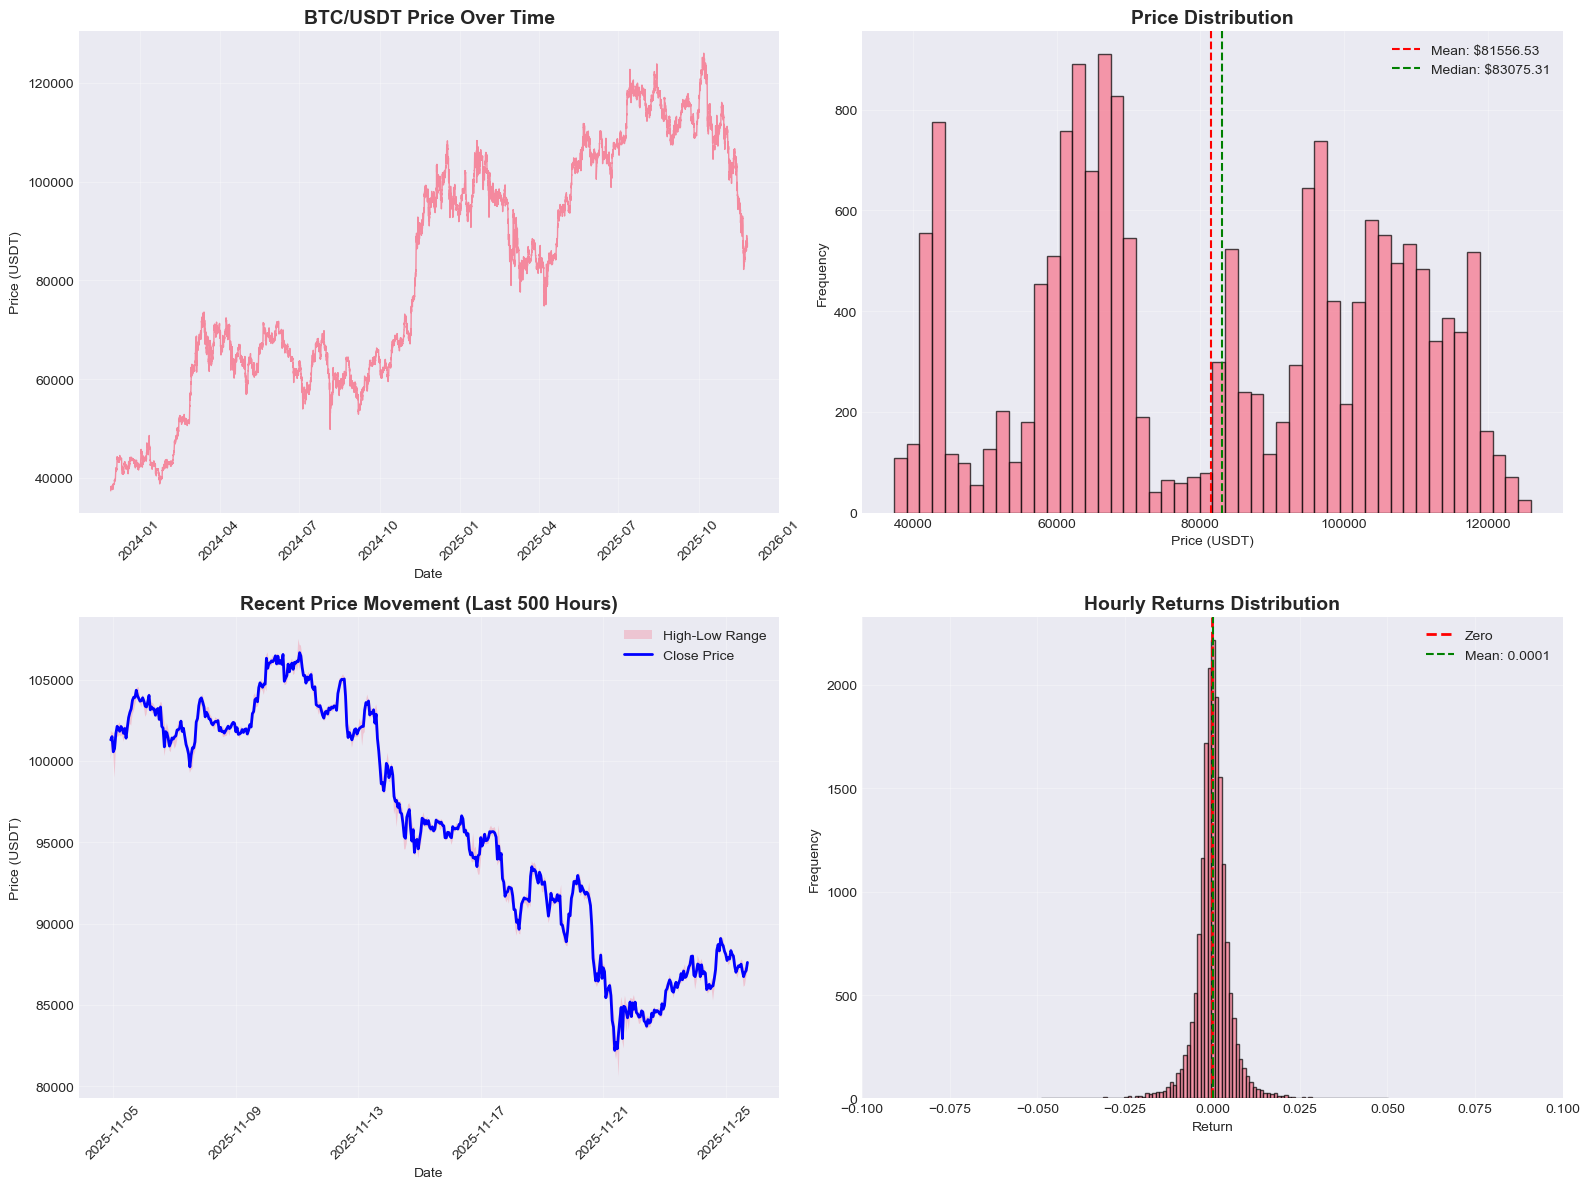


📊 Price Statistics:
   Min: $37367.36
   Max: $126011.18
   Mean: $81556.53
   Median: $83075.31
   Std: $23890.09


In [18]:
if HAS_RAW_DATA:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Price over time
    axes[0, 0].plot(df_raw.index, df_raw['close'], linewidth=1, alpha=0.8)
    axes[0, 0].set_title('BTC/USDT Price Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price (USDT)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Price distribution
    axes[0, 1].hist(df_raw['close'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(df_raw['close'].mean(), color='red', linestyle='--', 
                       label=f'Mean: ${df_raw["close"].mean():.2f}')
    axes[0, 1].axvline(df_raw['close'].median(), color='green', linestyle='--', 
                       label=f'Median: ${df_raw["close"].median():.2f}')
    axes[0, 1].set_title('Price Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Price (USDT)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: OHLC Candlestick-like visualization (last 500 hours)
    recent = df_raw.tail(500)
    axes[1, 0].fill_between(recent.index, recent['low'], recent['high'], 
                            alpha=0.3, label='High-Low Range')
    axes[1, 0].plot(recent.index, recent['close'], linewidth=2, label='Close Price', color='blue')
    axes[1, 0].set_title('Recent Price Movement (Last 500 Hours)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Price (USDT)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Daily returns distribution
    daily_returns = df_raw['close'].pct_change().dropna()
    axes[1, 1].hist(daily_returns, bins=100, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
    axes[1, 1].axvline(daily_returns.mean(), color='green', linestyle='--', 
                       label=f'Mean: {daily_returns.mean():.4f}')
    axes[1, 1].set_title('Hourly Returns Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Return')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(-0.1, 0.1)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Price Statistics:")
    print(f"   Min: ${df_raw['close'].min():.2f}")
    print(f"   Max: ${df_raw['close'].max():.2f}")
    print(f"   Mean: ${df_raw['close'].mean():.2f}")
    print(f"   Median: ${df_raw['close'].median():.2f}")
    print(f"   Std: ${df_raw['close'].std():.2f}")
else:
    print("⚠️ Raw price data not available. Skipping price analysis.")



## 4. Log Return Analysis

Log return is our target variable. Let's analyze its distribution and patterns.



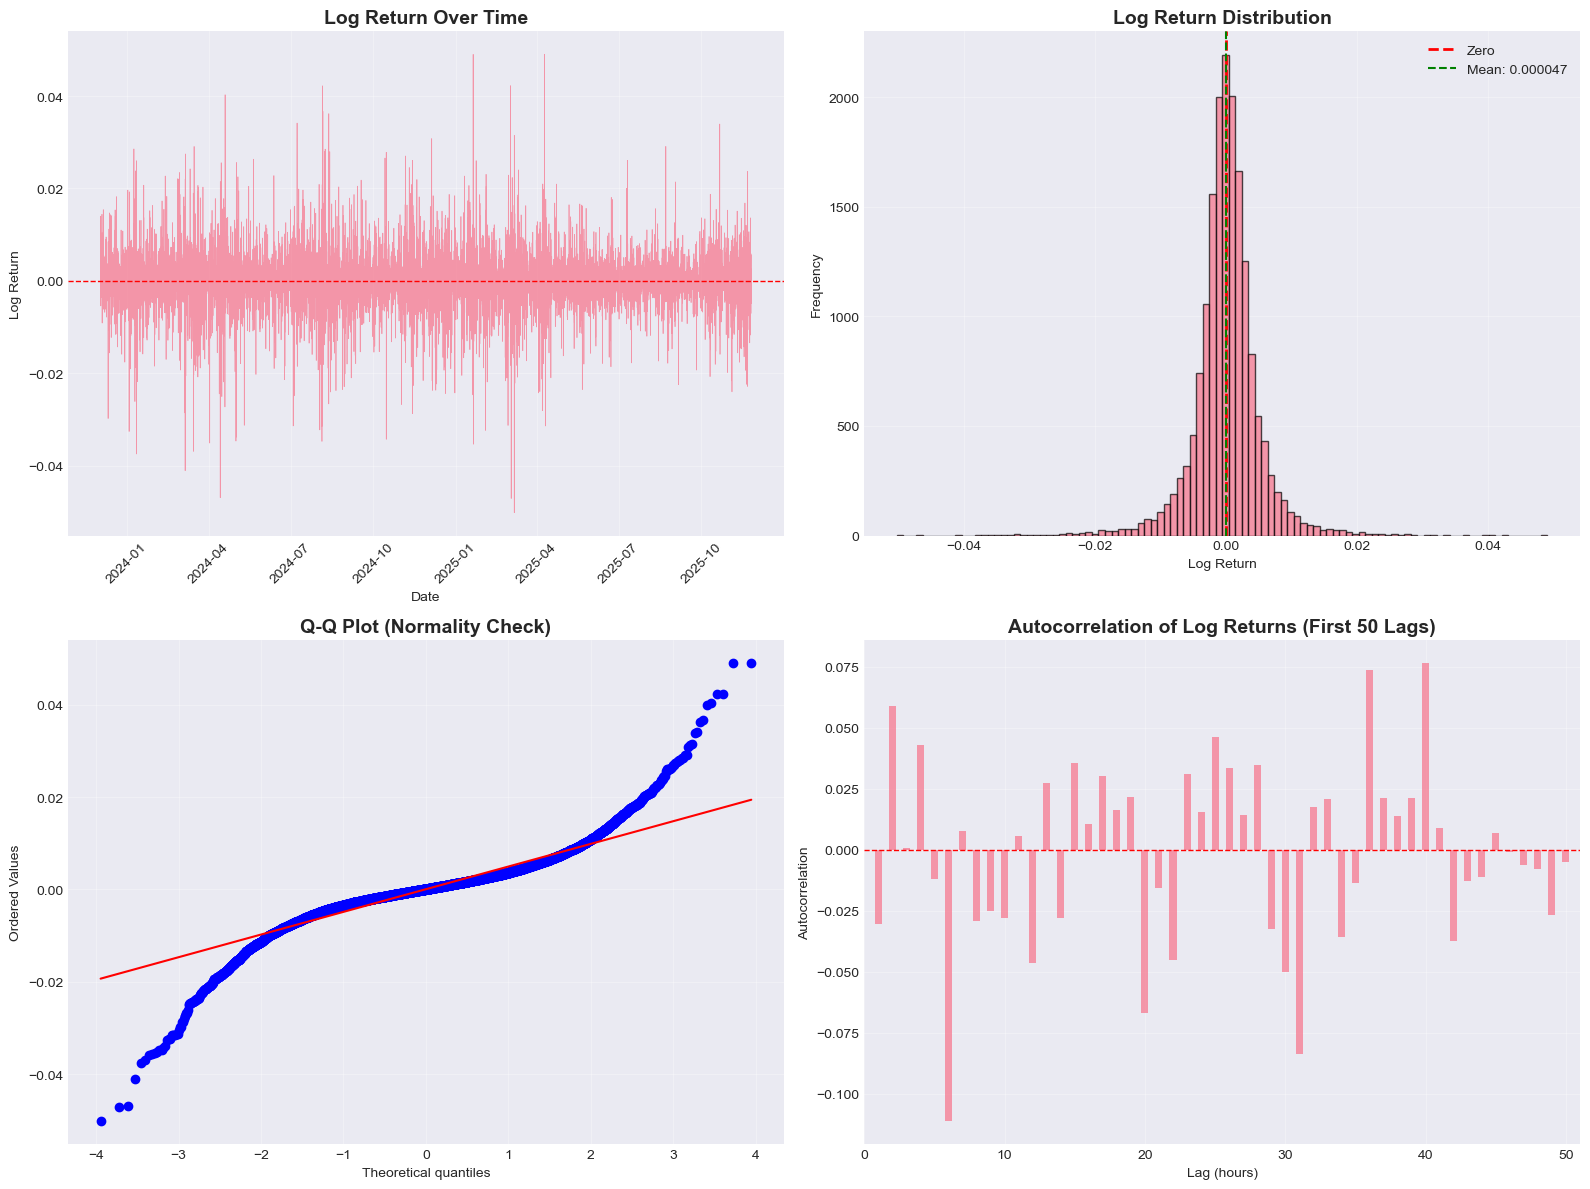


📊 Log Return Statistics:
   Mean: 0.00004695
   Std: 0.00519714
   Min: -0.05019453
   Max: 0.04904683
   Skewness: -0.2030
   Kurtosis: 9.4444


In [19]:
if 'log_return' in df_features.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Log return over time
    axes[0, 0].plot(df_features.index, df_features['log_return'], linewidth=0.5, alpha=0.7)
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title('Log Return Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Log Return')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Log return distribution
    axes[0, 1].hist(df_features['log_return'].dropna(), bins=100, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
    axes[0, 1].axvline(df_features['log_return'].mean(), color='green', linestyle='--', 
                       label=f'Mean: {df_features["log_return"].mean():.6f}')
    axes[0, 1].set_title('Log Return Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Log Return')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Q-Q plot for normality check
    log_returns_clean = df_features['log_return'].dropna()
    stats.probplot(log_returns_clean, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Autocorrelation
    sample_returns = df_features['log_return'].tail(1000).dropna()
    autocorr_values = [sample_returns.autocorr(lag=i) for i in range(1, 51)]
    lags = np.arange(1, 51)
    axes[1, 1].bar(lags, autocorr_values, width=0.5, alpha=0.7)
    axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[1, 1].set_title('Autocorrelation of Log Returns (First 50 Lags)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Lag (hours)')
    axes[1, 1].set_ylabel('Autocorrelation')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0, 51)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Log Return Statistics:")
    print(f"   Mean: {df_features['log_return'].mean():.8f}")
    print(f"   Std: {df_features['log_return'].std():.8f}")
    print(f"   Min: {df_features['log_return'].min():.8f}")
    print(f"   Max: {df_features['log_return'].max():.8f}")
    print(f"   Skewness: {df_features['log_return'].skew():.4f}")
    print(f"   Kurtosis: {df_features['log_return'].kurtosis():.4f}")



## 5. Feature Distribution Analysis



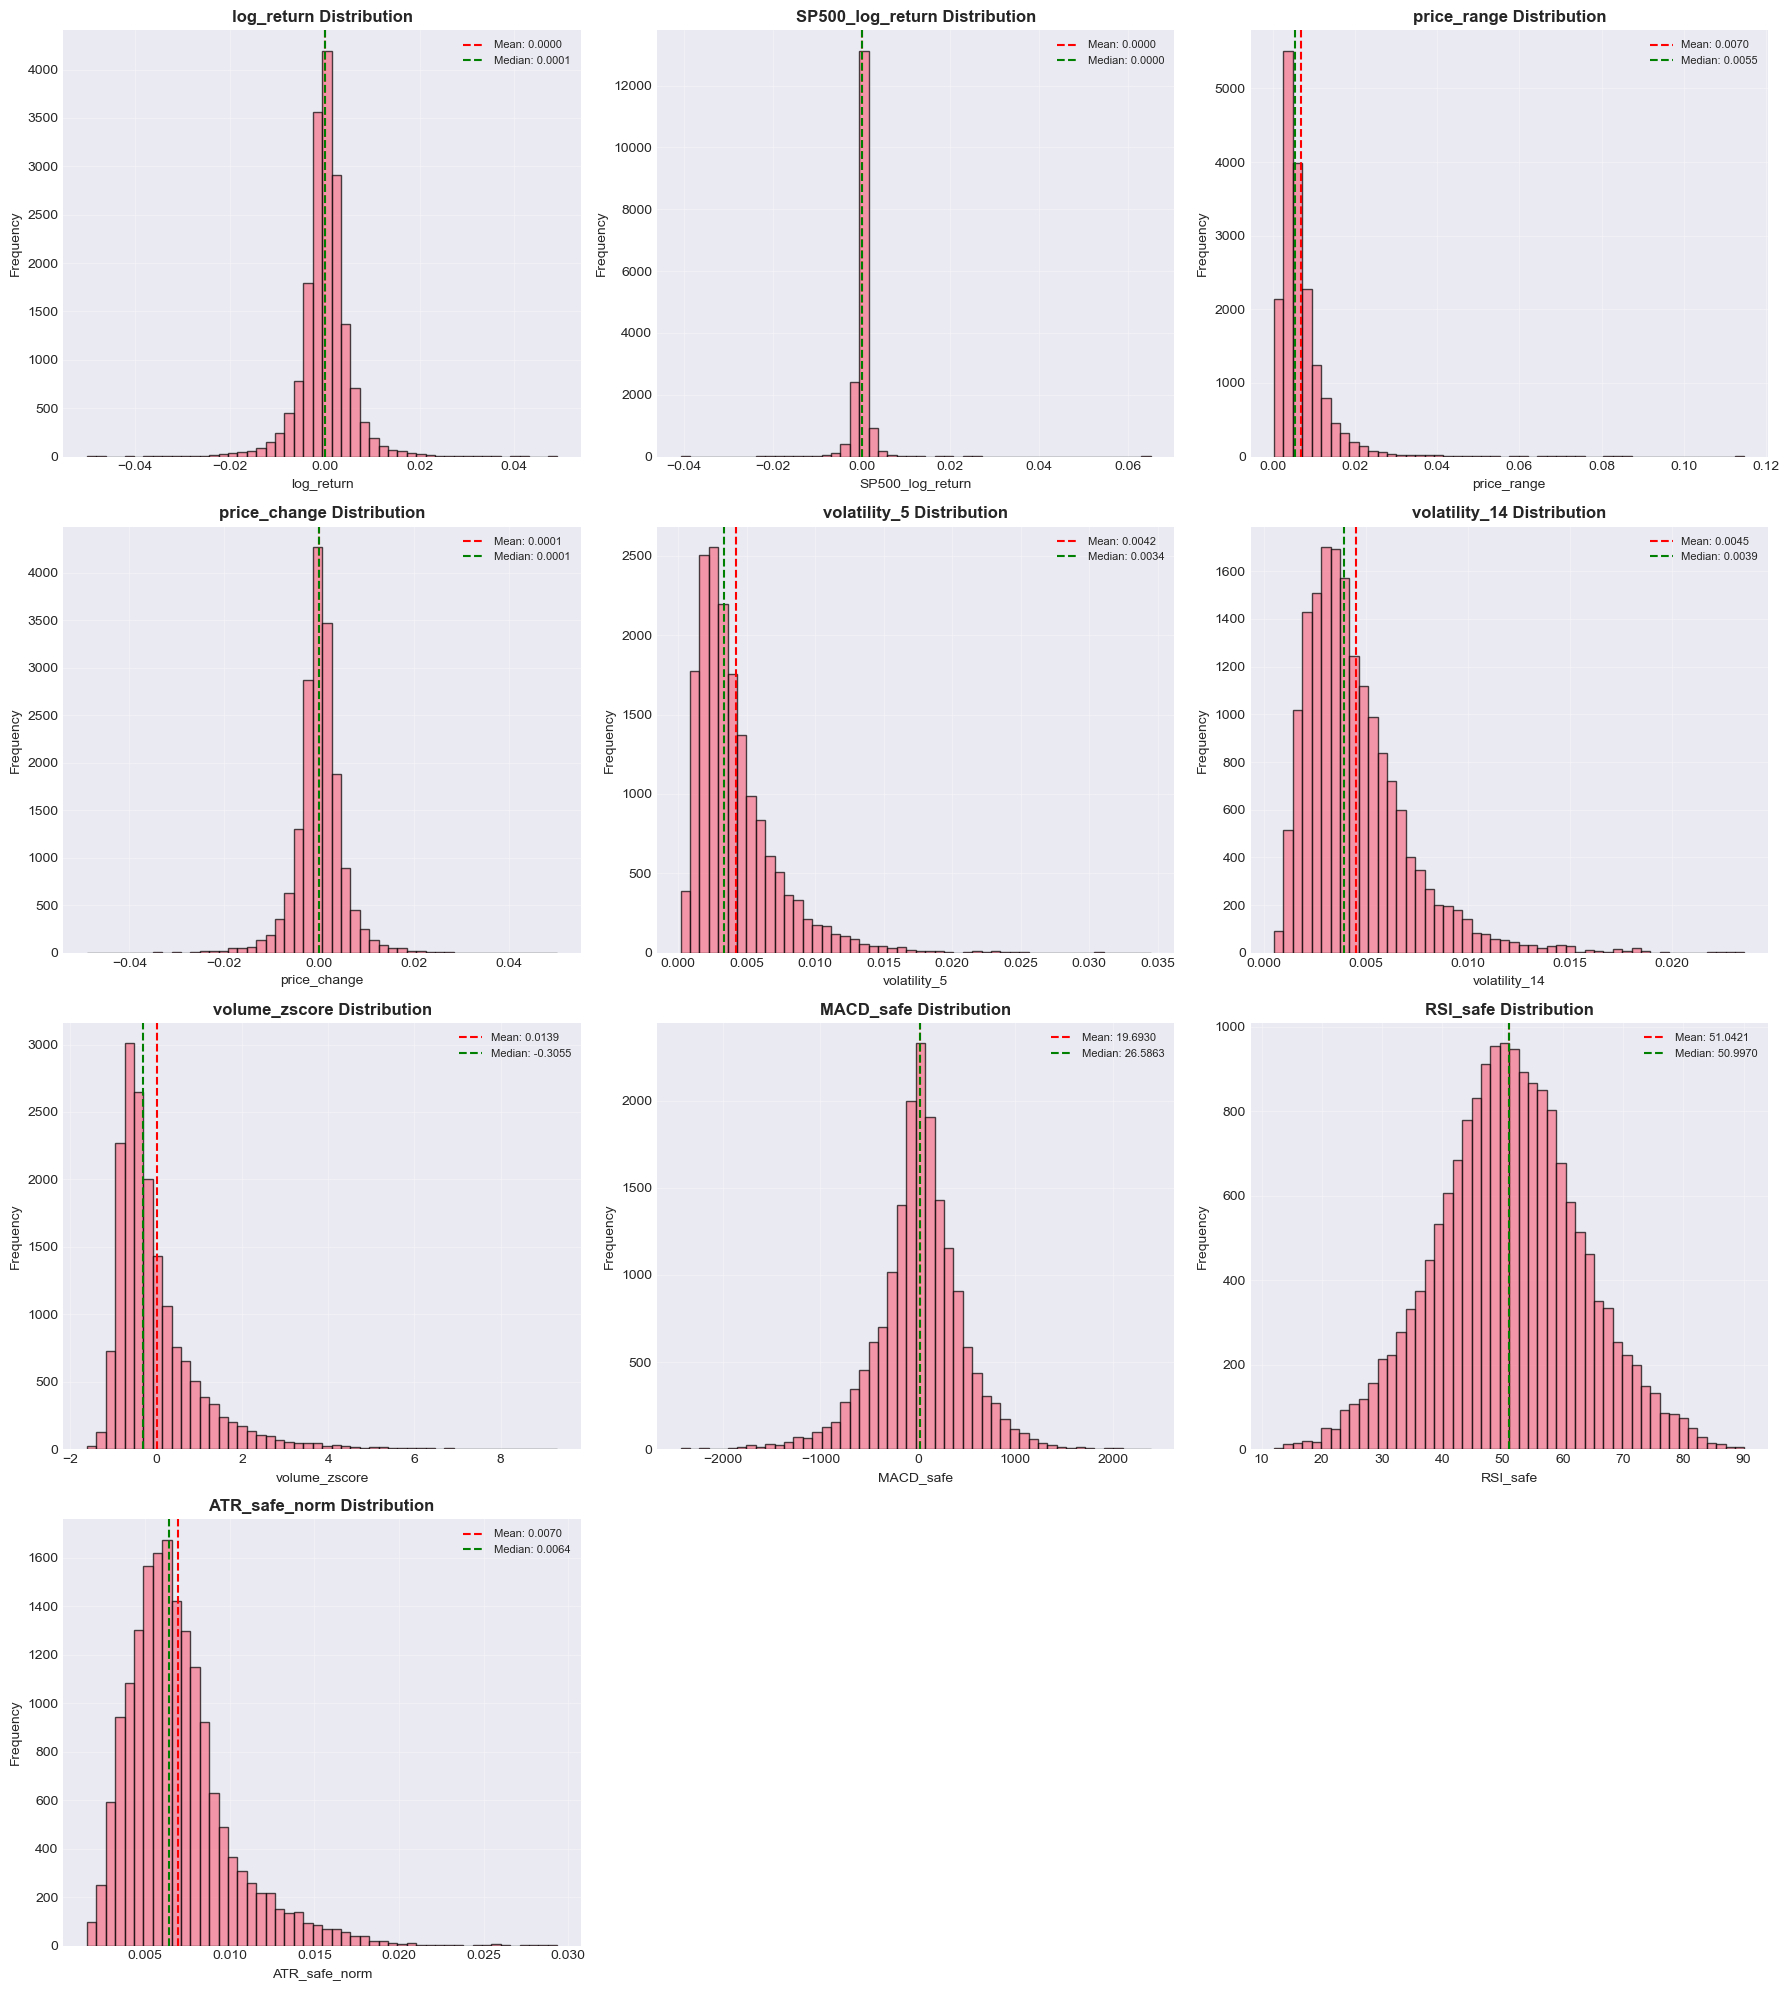

In [20]:
# Select numeric features for distribution analysis
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Plot distributions for key features
key_features = ['log_return', 'SP500_log_return', 'price_range', 'price_change',
                'volatility_5', 'volatility_14', 'volume_zscore', 
                'MACD_safe', 'RSI_safe', 'ATR_safe_norm']

# Filter to only features that exist
key_features = [f for f in key_features if f in numeric_features]

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for i, feature in enumerate(key_features):
    if i < len(axes):
        data = df_features[feature].dropna()
        axes[i].hist(data, bins=50, edgecolor='black', alpha=0.7)
        axes[i].axvline(data.mean(), color='red', linestyle='--', 
                       label=f'Mean: {data.mean():.4f}')
        axes[i].axvline(data.median(), color='green', linestyle='--', 
                       label=f'Median: {data.median():.4f}')
        axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



## 6. Correlation Analysis



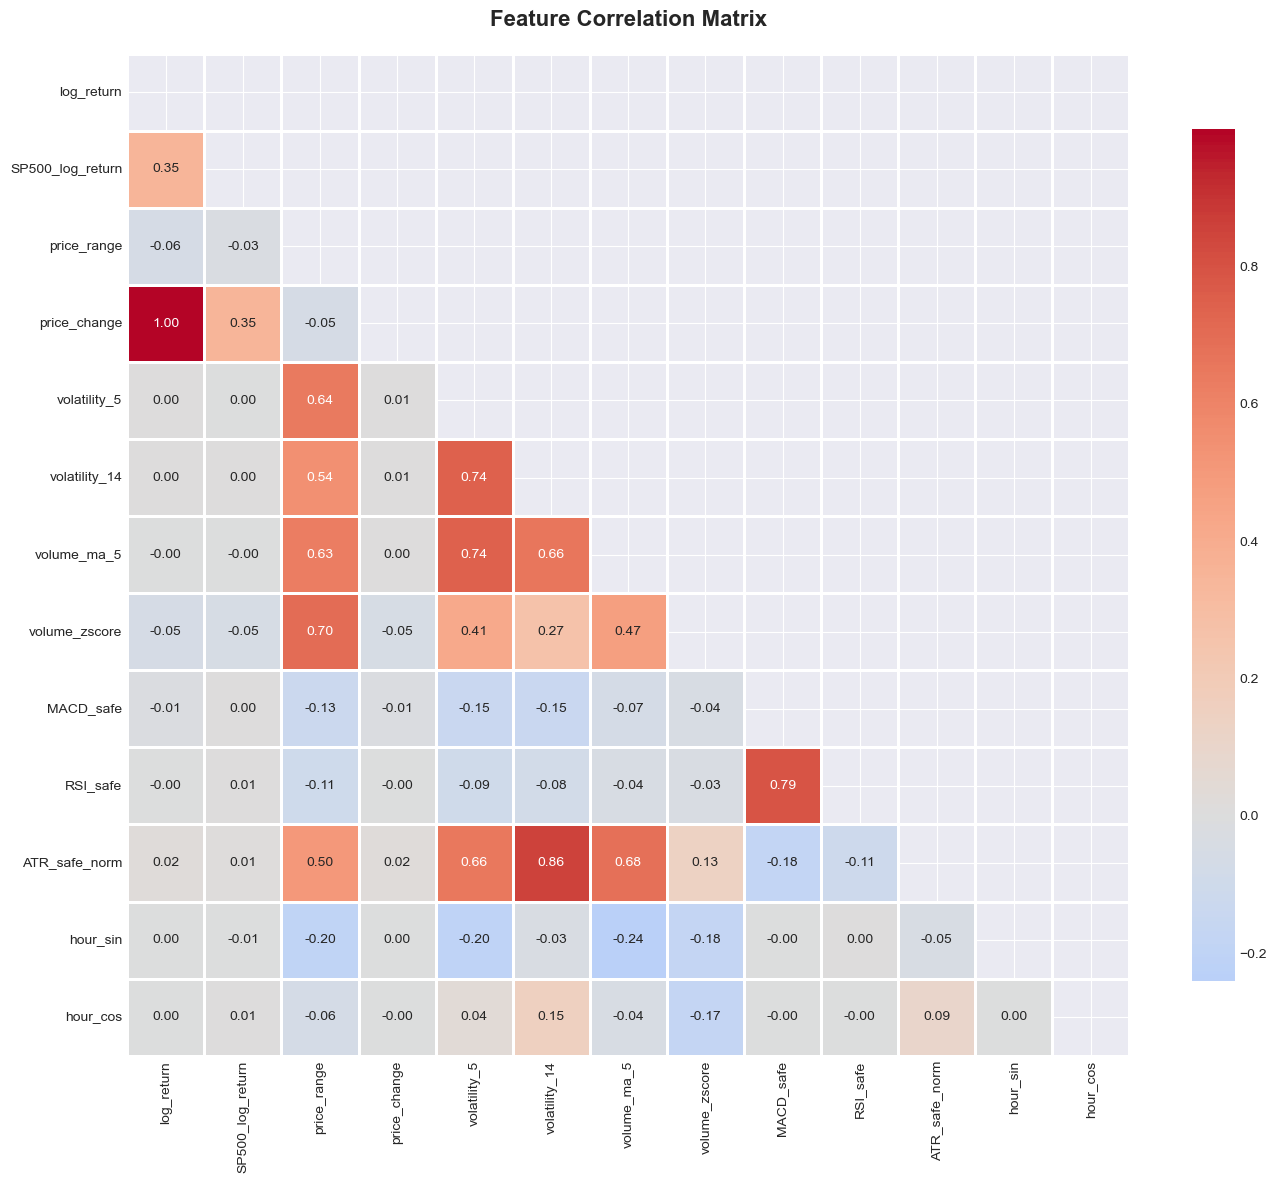


📊 Correlation with Log Return (target variable):
log_return          1.000000
price_change        0.999961
SP500_log_return    0.347118
ATR_safe_norm       0.019364
volatility_14       0.004831
volatility_5        0.002232
hour_sin            0.001628
hour_cos            0.000093
volume_ma_5        -0.000259
RSI_safe           -0.001306
MACD_safe          -0.013815
volume_zscore      -0.052021
price_range        -0.060140
Name: log_return, dtype: float64


In [21]:
# Correlation matrix
corr_matrix = df_features[numeric_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation with log_return (target)
if 'log_return' in corr_matrix.columns:
    corr_with_target = corr_matrix['log_return'].sort_values(ascending=False)
    print("\n📊 Correlation with Log Return (target variable):")
    print(corr_with_target)



## 7. Volatility Analysis



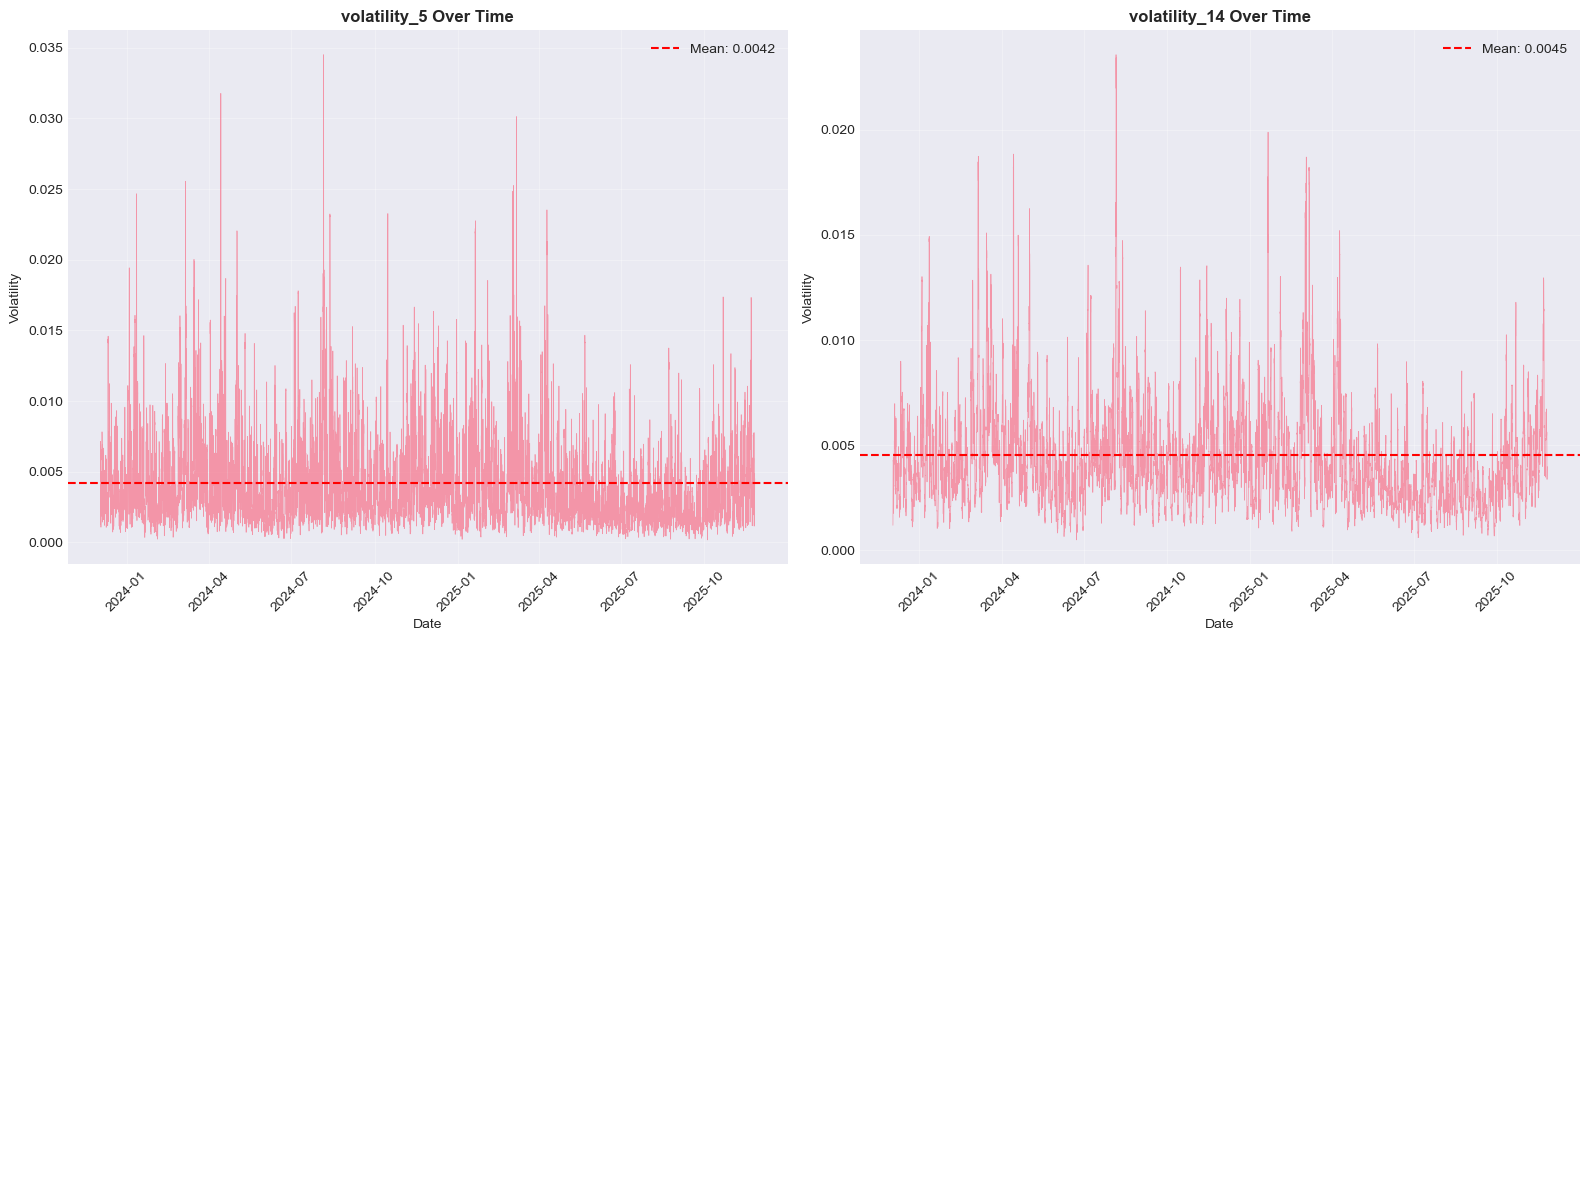

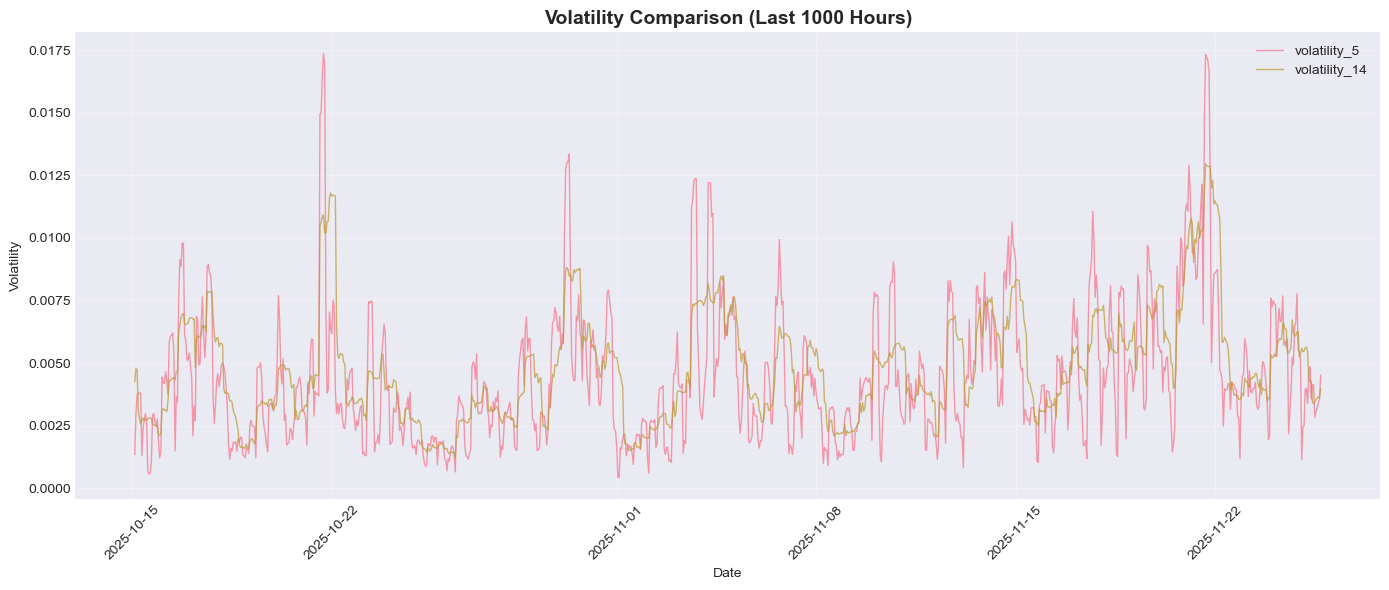

In [22]:
volatility_features = [f for f in numeric_features if 'volatility' in f.lower()]

if volatility_features:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, vol_feat in enumerate(volatility_features[:4]):
        if i < len(axes):
            data = df_features[vol_feat].dropna()
            
            # Time series
            axes[i].plot(df_features.index, data, linewidth=0.5, alpha=0.7)
            axes[i].axhline(data.mean(), color='red', linestyle='--', 
                           label=f'Mean: {data.mean():.4f}')
            axes[i].set_title(f'{vol_feat} Over Time', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Date')
            axes[i].set_ylabel('Volatility')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(len(volatility_features), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Compare different volatility windows
    if len(volatility_features) >= 2:
        fig, ax = plt.subplots(figsize=(14, 6))
        recent = df_features.tail(1000)
        for vol_feat in volatility_features:
            ax.plot(recent.index, recent[vol_feat], label=vol_feat, linewidth=1, alpha=0.7)
        ax.set_title('Volatility Comparison (Last 1000 Hours)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Volatility')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()



## 8. Technical Indicators Analysis



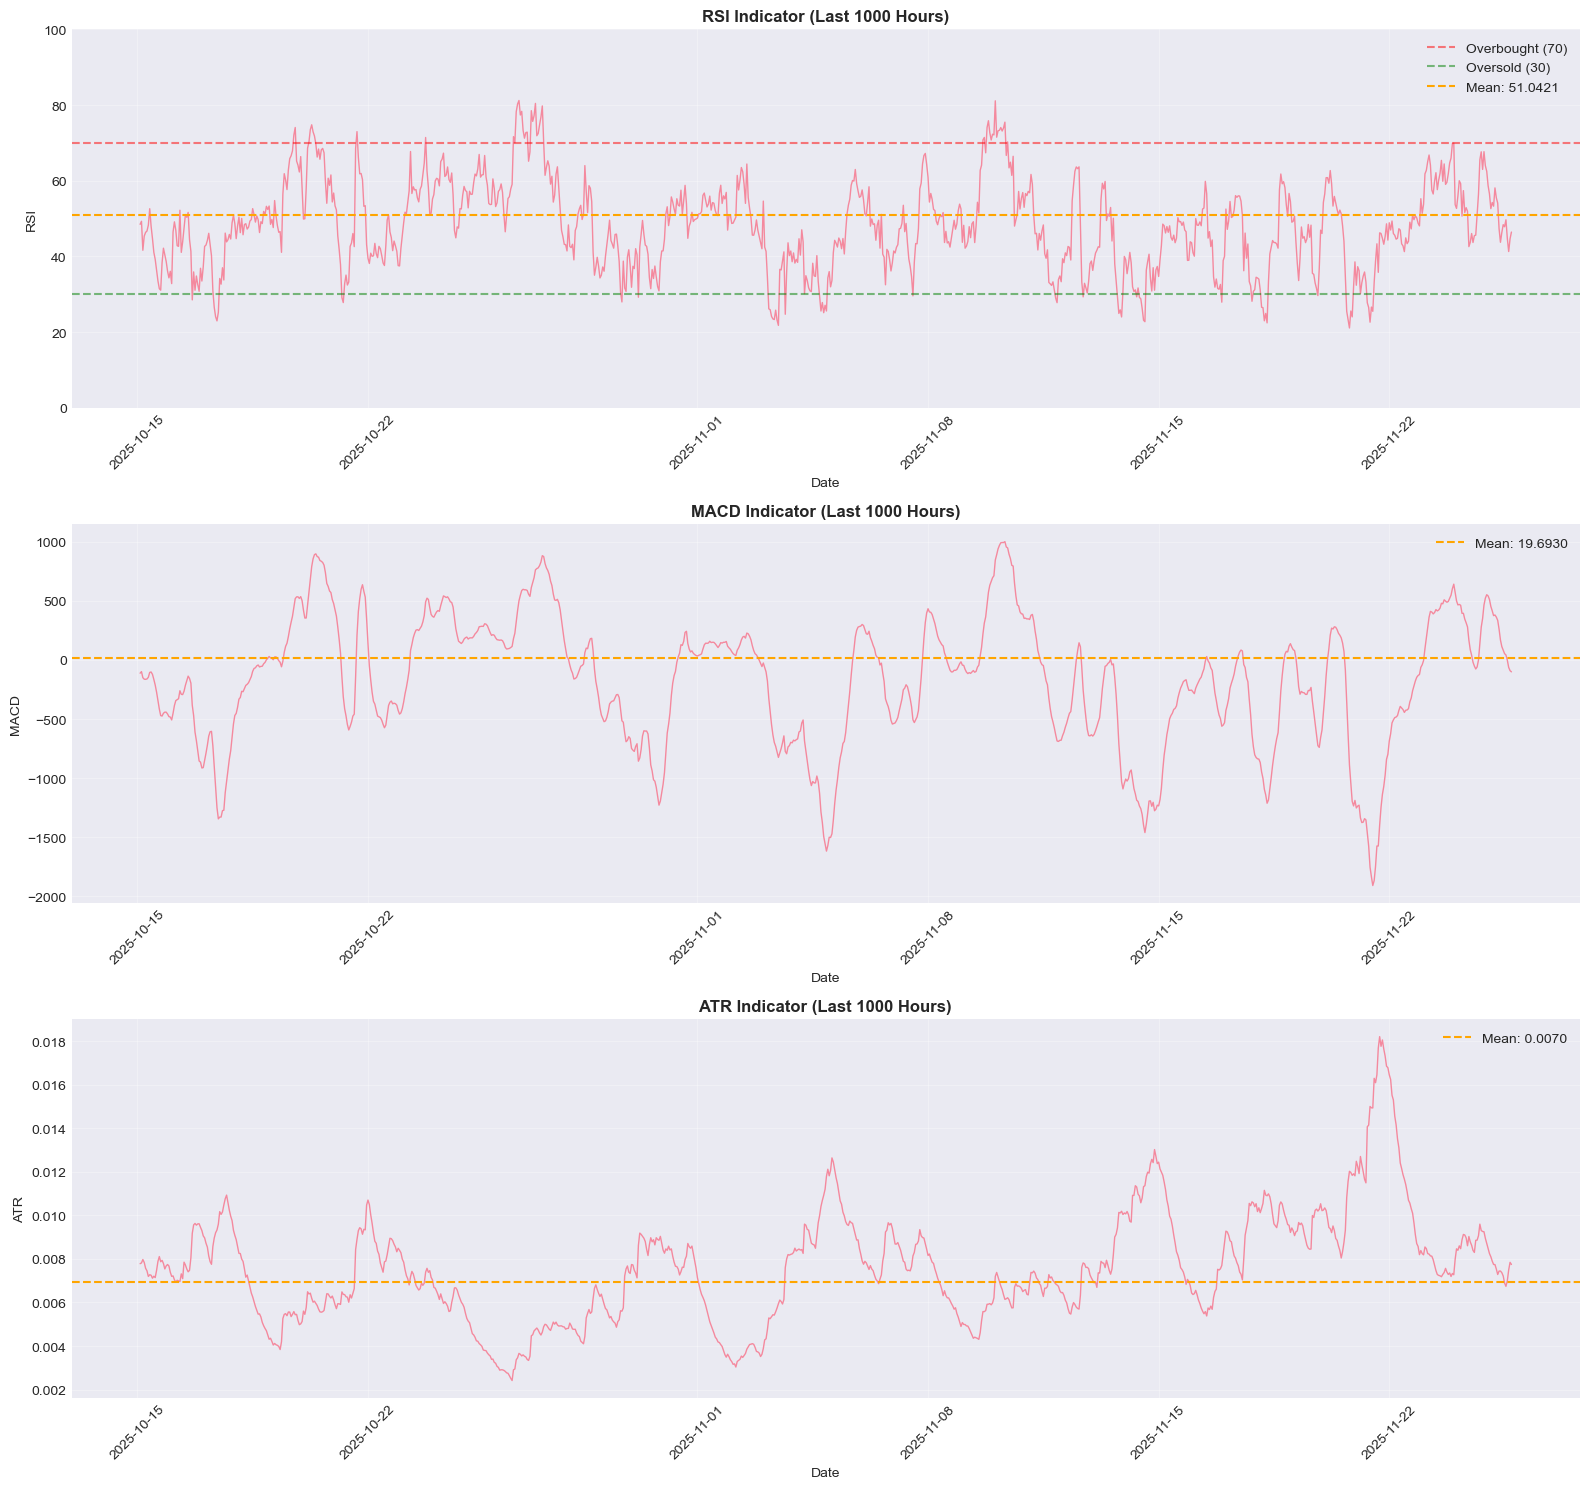

In [23]:
# Plot technical indicators
indicators = {}
if 'RSI_safe' in df_features.columns:
    indicators['RSI'] = df_features['RSI_safe']
if 'MACD_safe' in df_features.columns:
    indicators['MACD'] = df_features['MACD_safe']
if 'ATR_safe_norm' in df_features.columns:
    indicators['ATR'] = df_features['ATR_safe_norm']

if indicators:
    n_indicators = len(indicators)
    fig, axes = plt.subplots(n_indicators, 1, figsize=(16, 5 * n_indicators))
    if n_indicators == 1:
        axes = [axes]
    
    for i, (name, data) in enumerate(indicators.items()):
        recent = data.tail(1000).dropna()
        axes[i].plot(recent.index, recent, linewidth=1, alpha=0.8)
        
        if name == 'RSI':
            axes[i].axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
            axes[i].axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
            axes[i].set_ylim(0, 100)
        
        axes[i].axhline(data.mean(), color='orange', linestyle='--', 
                       label=f'Mean: {data.mean():.4f}')
        axes[i].set_title(f'{name} Indicator (Last 1000 Hours)', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(name)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()



## 9. Temporal Patterns Analysis

Analyzing patterns by hour of day, day of week, and month.



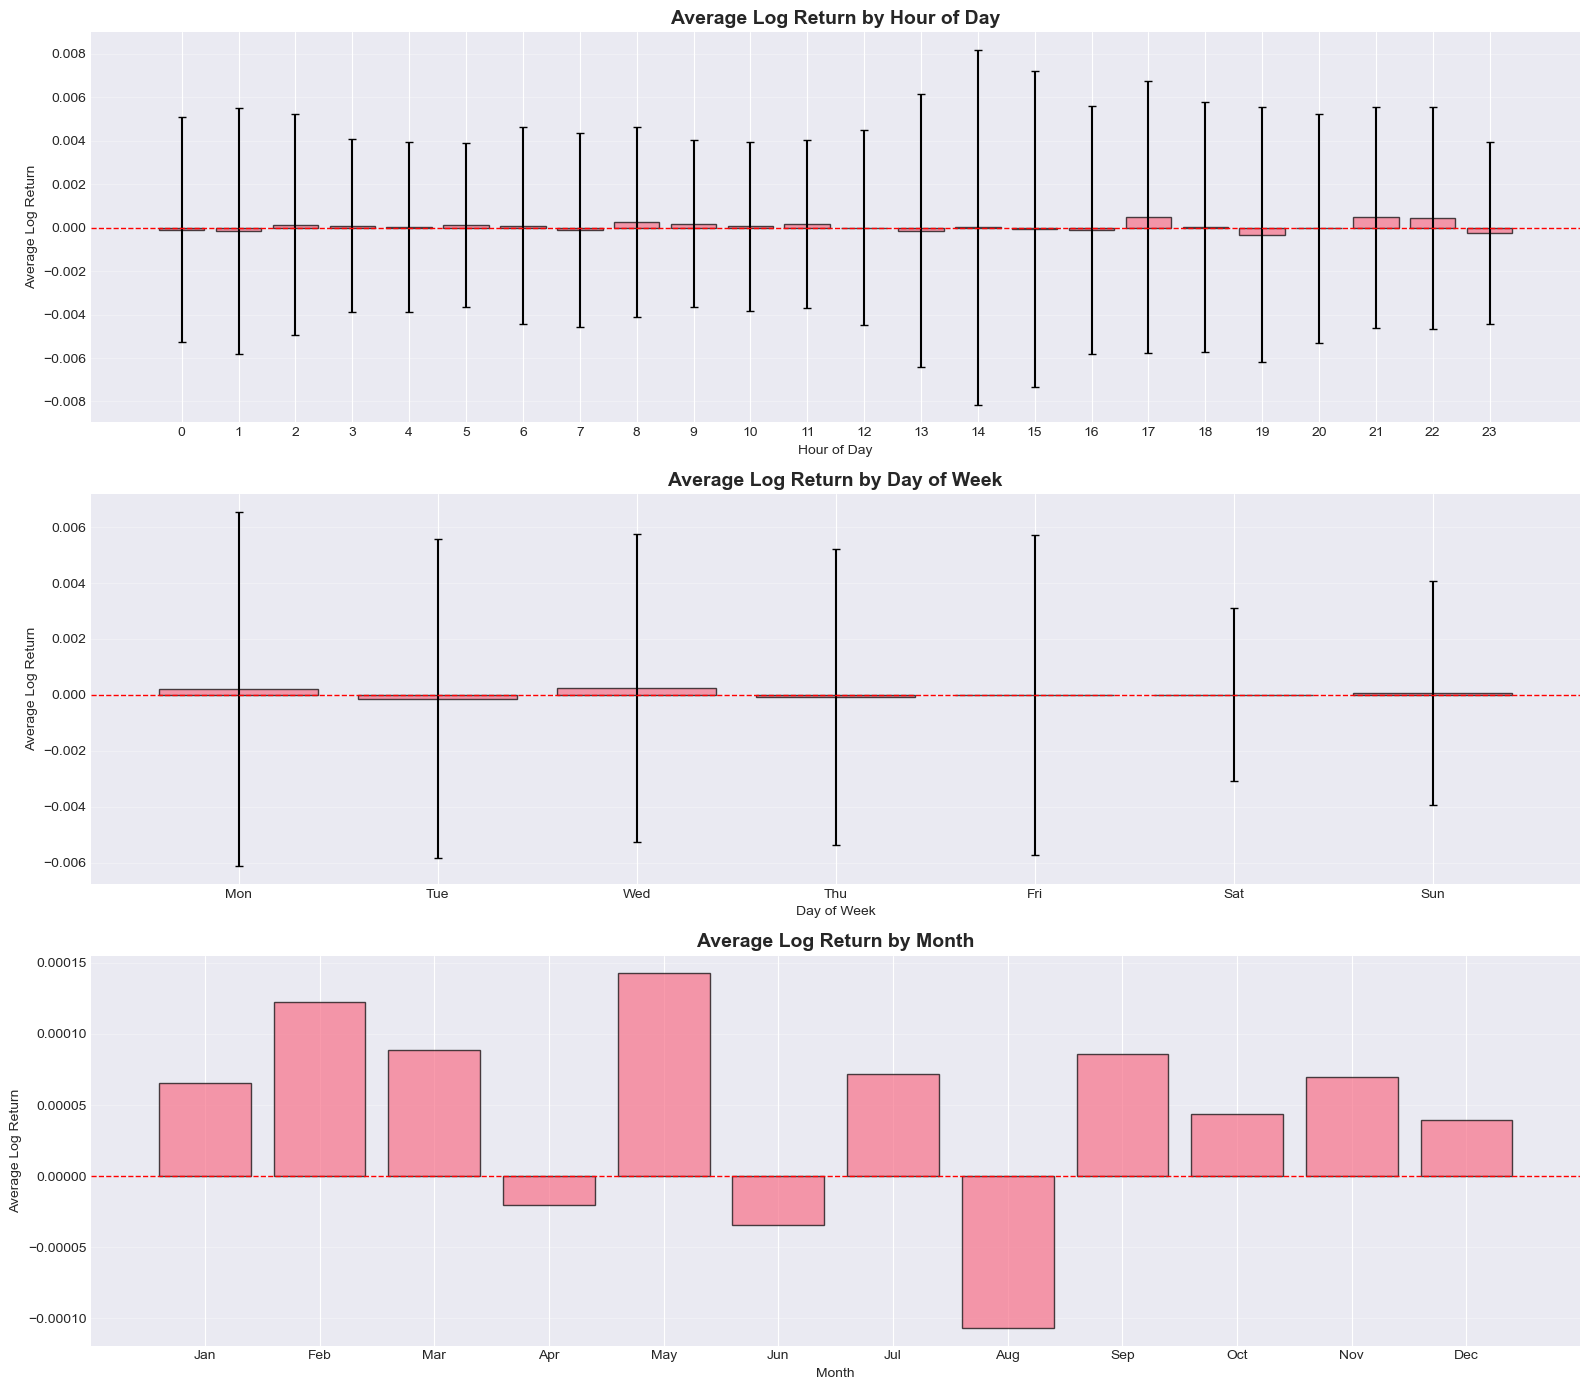

In [24]:
# Extract temporal features
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Hourly patterns
if 'log_return' in df_features.columns:
    hourly_returns = df_features.groupby('hour')['log_return'].mean()
    hourly_std = df_features.groupby('hour')['log_return'].std()
    
    axes[0].bar(hourly_returns.index, hourly_returns.values, alpha=0.7, 
                yerr=hourly_std.values, capsize=3, edgecolor='black')
    axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0].set_title('Average Log Return by Hour of Day', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Average Log Return')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_xticks(range(0, 24))

# Daily patterns
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_returns = df_features.groupby('day_of_week')['log_return'].mean()
daily_std = df_features.groupby('day_of_week')['log_return'].std()

axes[1].bar(range(7), daily_returns.values, alpha=0.7, 
            yerr=daily_std.values, capsize=3, edgecolor='black')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Average Log Return by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Log Return')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)
axes[1].grid(True, alpha=0.3, axis='y')

# Monthly patterns
monthly_returns = df_features.groupby('month')['log_return'].mean()
monthly_std = df_features.groupby('month')['log_return'].std()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[2].bar(range(1, 13), [monthly_returns.get(m, 0) for m in range(1, 13)], 
            alpha=0.7, edgecolor='black')
axes[2].axhline(0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('Average Log Return by Month', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Average Log Return')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_names)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



## 10. Volume Analysis



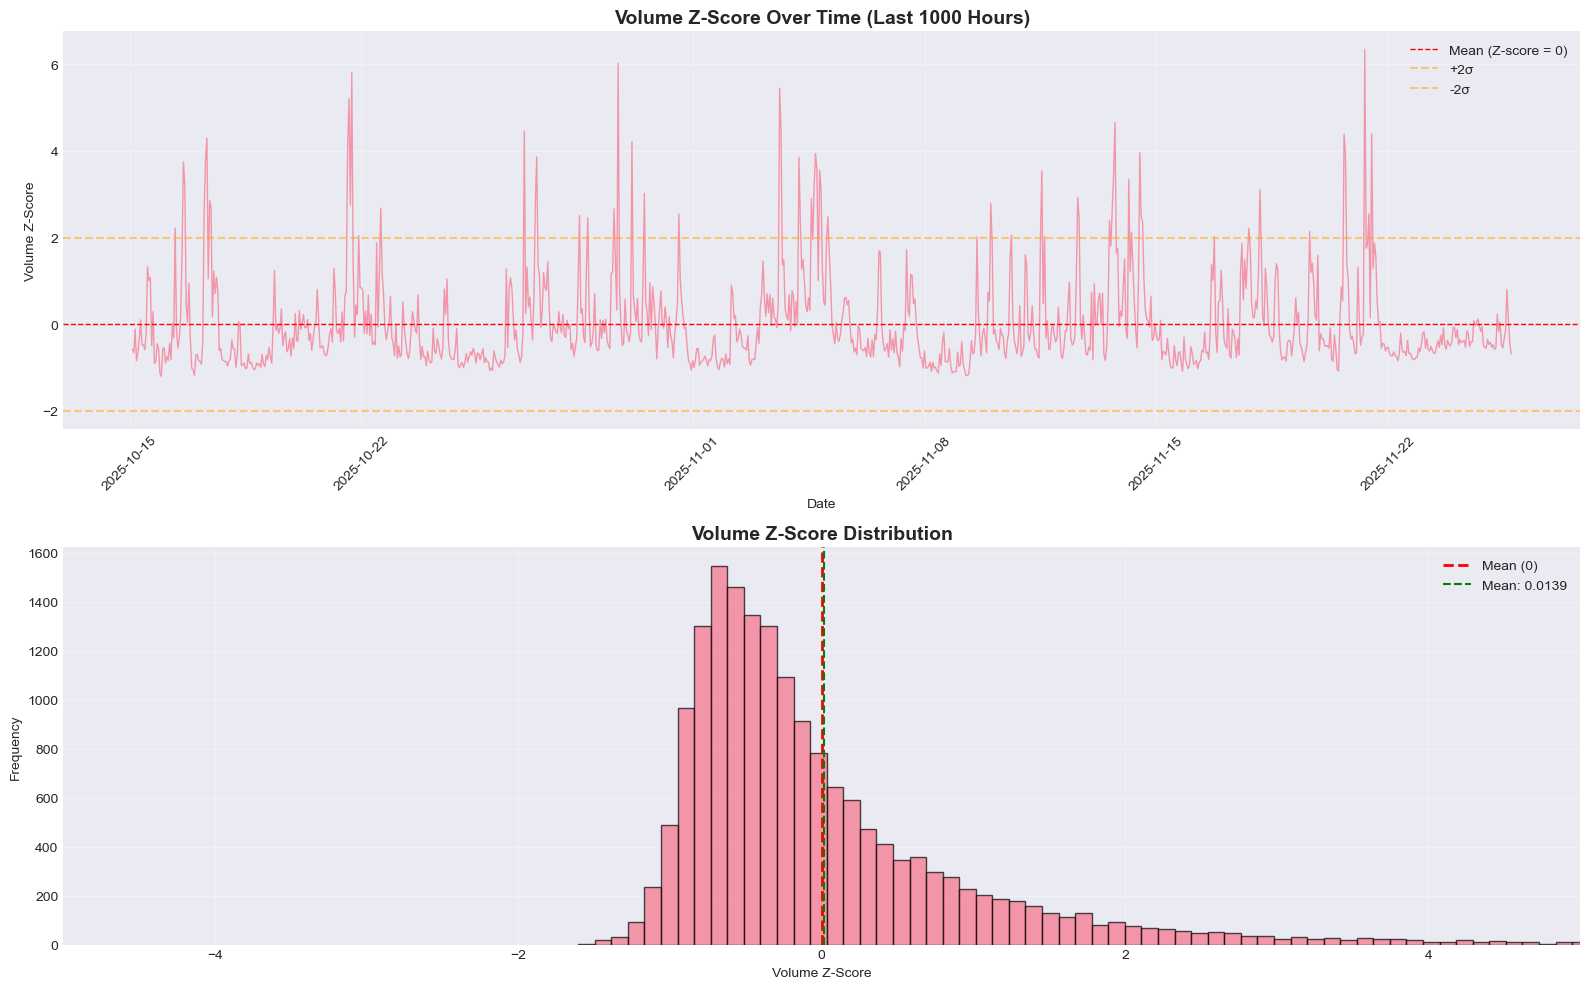

In [25]:
volume_features = [f for f in numeric_features if 'volume' in f.lower()]

if volume_features:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Volume over time
    if 'volume_zscore' in df_features.columns:
        recent = df_features.tail(1000)['volume_zscore'].dropna()
        axes[0].plot(recent.index, recent, linewidth=1, alpha=0.7)
        axes[0].axhline(0, color='red', linestyle='--', linewidth=1, label='Mean (Z-score = 0)')
        axes[0].axhline(2, color='orange', linestyle='--', alpha=0.5, label='+2σ')
        axes[0].axhline(-2, color='orange', linestyle='--', alpha=0.5, label='-2σ')
        axes[0].set_title('Volume Z-Score Over Time (Last 1000 Hours)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Volume Z-Score')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)
    
    # Volume distribution
    if 'volume_zscore' in df_features.columns:
        data = df_features['volume_zscore'].dropna()
        axes[1].hist(data, bins=100, edgecolor='black', alpha=0.7)
        axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean (0)')
        axes[1].axvline(data.mean(), color='green', linestyle='--', 
                       label=f'Mean: {data.mean():.4f}')
        axes[1].set_title('Volume Z-Score Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Volume Z-Score')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_xlim(-5, 5)
    
    plt.tight_layout()
    plt.show()



## 11. Data Quality and Summary



In [26]:
print("=" * 80)
print("DATA QUALITY SUMMARY")
print("=" * 80)

print(f"\n✅ Total Records: {len(df_features)}")
print(f"✅ Date Range: {df_features.index.min()} to {df_features.index.max()}")
print(f"✅ Duration: {(df_features.index.max() - df_features.index.min()).days} days")
print(f"✅ Features: {len(numeric_features)}")

# Check for gaps in time series
time_diff = df_features.index.to_series().diff()
expected_hour = pd.Timedelta(hours=1)
gaps = time_diff[time_diff > expected_hour * 1.5]  # More than 1.5 hours gap

print(f"\n📊 Time Series Quality:")
print(f"   Missing hours: {len(gaps)}")
if len(gaps) > 0:
    print(f"   Largest gap: {gaps.max()}")
    print(f"   Gaps location: {gaps.head(10).index.tolist()}")
else:
    print("   ✅ No significant gaps detected")

# Feature importance preview (correlation with target)
if 'log_return' in df_features.columns:
    print(f"\n📊 Top Features Correlated with Log Return:")
    corr_target = df_features[numeric_features].corrwith(df_features['log_return']).abs().sort_values(ascending=False)
    for i, (feature, corr) in enumerate(corr_target.head(10).items()):
        if feature != 'log_return':
            print(f"   {i+1}. {feature}: {corr:.4f}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)



DATA QUALITY SUMMARY

✅ Total Records: 17377
✅ Date Range: 2023-12-02 17:00:00 to 2025-11-25 17:00:00
✅ Duration: 724 days
✅ Features: 13

📊 Time Series Quality:
   Missing hours: 0
   ✅ No significant gaps detected

📊 Top Features Correlated with Log Return:
   2. price_change: 1.0000
   3. SP500_log_return: 0.3471
   4. price_range: 0.0601
   5. volume_zscore: 0.0520
   6. ATR_safe_norm: 0.0194
   7. MACD_safe: 0.0138
   8. volatility_14: 0.0048
   9. volatility_5: 0.0022
   10. hour_sin: 0.0016

ANALYSIS COMPLETE
